# Librerías y modelos

In [1]:
print(__doc__)

import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import itertools
from sklearn import preprocessing

Automatically created module for IPython interactive environment


In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

## Recopilamos los modelos

In [3]:
names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Nearest Neighbors', 
         'Neural Net']

#'Linear SVM', 'RBF SVM'
#'Gaussian Process', 'QDA'

classifiers = [
    DecisionTreeClassifier(), 
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
#    SVC(kernel="linear", C=0.025),
#    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(max_iter=1000)]
#    AdaBoostClassifier(),
#    GaussianNB(),
#    QuadraticDiscriminantAnalysis(),
#    LogisticRegression()]

parametros=[{'max_depth': range(2,21), 'min_samples_split': range(2,100,5)},
            {'max_depth': range(2,21)},
            {'max_depth': range(2,11)},
            {'n_neighbors': range(3,71,4)},
            {'hidden_layer_sizes': [(v,) for v in range(20,101,10)]}]

dict_modelos = {}
for i in range(len(names)):
    dict_modelos[names[i]]={'Modelo': classifiers[i], 'Params': parametros[i]}

dict_modelos

{'Decision Tree': {'Modelo': DecisionTreeClassifier(),
  'Params': {'max_depth': range(2, 21),
   'min_samples_split': range(2, 100, 5)}},
 'Random Forest': {'Modelo': RandomForestClassifier(),
  'Params': {'max_depth': range(2, 21)}},
 'Gradient Boosting': {'Modelo': GradientBoostingClassifier(),
  'Params': {'max_depth': range(2, 11)}},
 'Nearest Neighbors': {'Modelo': KNeighborsClassifier(),
  'Params': {'n_neighbors': range(3, 71, 4)}},
 'Neural Net': {'Modelo': MLPClassifier(max_iter=1000),
  'Params': {'hidden_layer_sizes': [(20,),
    (30,),
    (40,),
    (50,),
    (60,),
    (70,),
    (80,),
    (90,),
    (100,)]}}}

In [4]:
ot_names = ['AdaBoost', 'Naive Bayes', 'Logistic Regression']


ot_classifiers = [
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression()]


dict_otros_modelos = {}
for i in range(len(ot_names)):
    dict_otros_modelos[ot_names[i]]={'Best': ot_classifiers[i]}

dict_otros_modelos

{'AdaBoost': {'Best': AdaBoostClassifier()},
 'Naive Bayes': {'Best': GaussianNB()},
 'Logistic Regression': {'Best': LogisticRegression()}}

# Sin bins y con items

## Carga y división de datos

In [5]:
data = pd.read_csv('Demographic_Data.csv')
data = data.rename(columns={name:name.capitalize() for name in data.columns})
data = data[['Region','Age','Items','Amount','In-store']]
data.head()

,Region,Age,Items,Amount,In-store
0,2,37,4,281.03,0
1,2,35,2,219.51,0
2,4,45,3,1525.70,1
3,3,46,3,715.25,1
4,1,33,4,1937.50,1


In [6]:
#features
X = data.iloc[:,0:4]
y = data.iloc[:,4]

In [7]:
#Train/Test Split (que conste que esta división no separa a partes iguales los datos de cada region, y esto puede ser un fallo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train.iloc[:,0:4])
X_tr_scaled = scaler.transform(X_train.iloc[:,0:4])
X_tr_scaled=pd.DataFrame(X_tr_scaled, columns=X_train.columns[0:4], index=X_train.index)
X_tr_scaled
#X_tr_scaled

,Region,Age,Items,Amount
25183,1.176482,-1.194424,-0.248618,-0.185834
37715,1.176482,-0.114465,-0.734116,-0.012337
38347,-0.600538,0.266696,0.236880,-0.719665
4589,-1.489048,-1.639112,-0.248618,1.511286
78269,0.287972,-0.686208,-0.734116,2.315529
...,...,...,...,...
63206,-0.600538,2.236032,0.722378,-1.122154
61404,-0.600538,-0.368573,-0.248618,-0.835053
17730,1.176482,-0.495627,-1.219614,1.073176
28030,1.176482,-1.702639,-0.734116,1.717652


## Uso GridSearchCV

In [9]:
scorr = {'Accuracy': 'accuracy', 'F1_avg': 'f1_weighted'}
cosas=[scorr.keys(),['mean_test_','rank_test_']]
cosas0=[]
for element in itertools.product(*cosas):
        cosas0.append(element[1]+element[0])

In [10]:
#Por defecto toma cv=5

mod_entrenados={}

for name in dict_modelos.keys():
    names_col_imp=[]
    cosas1=['param_'+v for v in dict_modelos[name]['Params'].keys()]
    names_col_imp=['params']+cosas1+cosas0
    
    gs = GridSearchCV(dict_modelos[name]['Modelo'],
                      param_grid=dict_modelos[name]['Params'],
                      scoring=scorr, refit='F1_avg', cv=5)
    gs.fit(X_tr_scaled, y_train)
    mod_entrenados[name]={'Mod_ent': gs, 'Tabla': pd.DataFrame(gs.cv_results_)[names_col_imp], 'Best': gs.best_estimator_}
    print(f'Para el modelo {name}, el mejor estimador es {gs.best_estimator_}.')
    print()
mod_entrenados['Neural Net']['Tabla']['param_hidden_layer_sizes']=list(range(20,101,10))

Para el modelo Decision Tree, el mejor estimador es DecisionTreeClassifier(max_depth=9).

Para el modelo Random Forest, el mejor estimador es RandomForestClassifier(max_depth=15).

Para el modelo Gradient Boosting, el mejor estimador es GradientBoostingClassifier(max_depth=5).

Para el modelo Nearest Neighbors, el mejor estimador es KNeighborsClassifier(n_neighbors=47).

Para el modelo Neural Net, el mejor estimador es MLPClassifier(max_iter=1000).



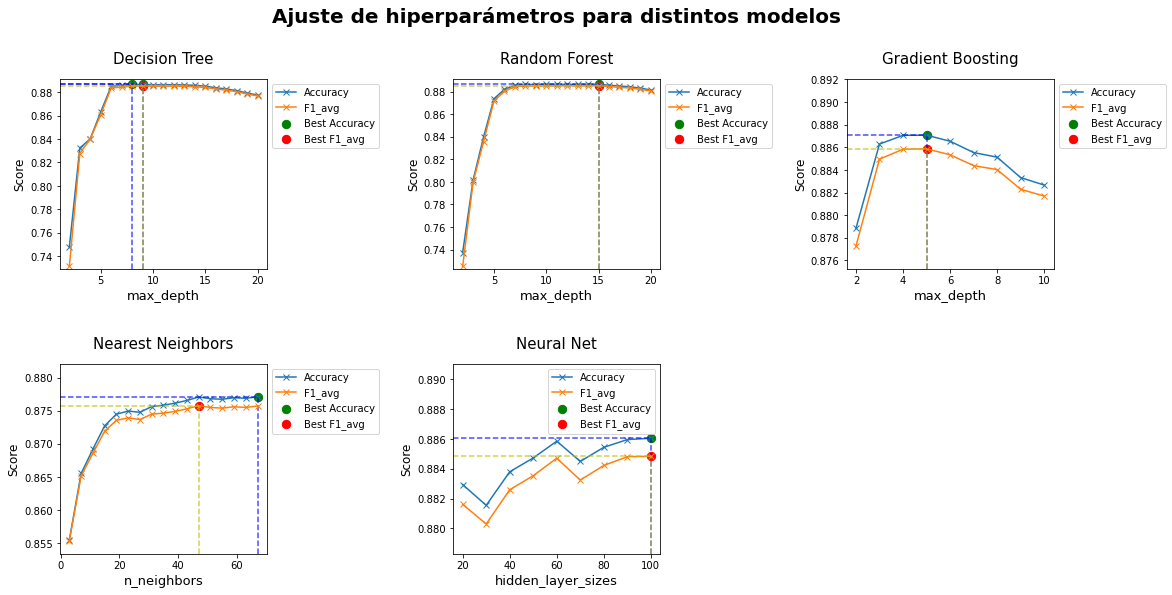

In [11]:
color = ['b', 'y']
color2 = ['g', 'r']
fig, axes_gs = plt.subplots(2,3)

j = -1
for n in mod_entrenados.keys():
    j = j+1
    colu = 'param_'+list(parametros[j])[0]
    if j==0:
        resultados = mod_entrenados[n]['Tabla'][mod_entrenados[n]['Tabla']['param_min_samples_split']==2]
    else :
        resultados = mod_entrenados[n]['Tabla']
    axes_gs[j//3,j%3].set_ylim(min(resultados.iloc[:,-4].min(), resultados.iloc[:,-2].min())-0.002, max(resultados.iloc[:,-4].max(),resultados.iloc[:,-2].max())+0.005)
    for i in range(len(scorr)):   
        axes_gs[j//3,j%3].plot(resultados[colu], resultados.iloc[:,2*i-4], 'x-', label=list(scorr.keys())[i])
        fff=resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()]
        axes_gs[j//3,j%3].scatter(fff,np.full((1,len(fff)),resultados.iloc[:,2*i-4].max()), s=70, color = color2[i], label='Best '+list(scorr.keys())[i])
        limite_y=(resultados.iloc[:,2*i-4].max()-axes_gs[j//3,j%3].set_ylim()[0])/(axes_gs[j//3,j%3].set_ylim()[1]-axes_gs[j//3,j%3].set_ylim()[0])
        for k in range(len(fff)):
            limite_x=(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k]-axes_gs[j//3,j%3].set_xlim()[0])/(axes_gs[j//3,j%3].set_xlim()[1]-axes_gs[j//3,j%3].set_xlim()[0])
            axes_gs[j//3,j%3].axhline(resultados.iloc[:,2*i-4].max(), xmax=limite_x, ls='--', color=color[i], alpha=0.7)
            axes_gs[j//3,j%3].axvline(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k], ymax=limite_y, ls='--', color=color[i], alpha=0.7)
    axes_gs[j//3,j%3].legend(bbox_to_anchor=(1, 1))
    axes_gs[j//3,j%3].set_xlabel(list(parametros[j])[0], size=13)
    axes_gs[j//3,j%3].set_ylabel('Score', size=12)
    axes_gs[j//3,j%3].set_title(n, size=15, y =1.05)

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2.3, 
                    top=1.65, 
                    wspace=0.9, 
                    hspace=0.5)
axes_gs[-1, -1].axis('off')
fig.suptitle('Ajuste de hiperparámetros para distintos modelos', size=20, x=1.15, y=1.9, fontweight ="bold")
plt.show()
#plt.xticks(list(range(0,29)), resultados.param_max_depth);

In [12]:
mod_entrenados.update(dict_otros_modelos)

## Entreno los best estimator y comparo

Primero modificamos los datos X_test para adecuarlos a la escala:

In [13]:
X_test_scaled = scaler.transform(X_test.iloc[:,0:4])
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X_test.columns[0:4], index=X_test.index)

In [83]:
regiones=['Online','Tienda','Accuracy','Macro_avg','Weighted_avg']
for name in mod_entrenados.keys():
    model = mod_entrenados[name]['Best'].fit(X_tr_scaled, y_train)
    preds = model.predict(X_tr_scaled)
    mod_entrenados[name]['Preds_for_best'] = preds
    mod_entrenados[name]['Class_report'] = pd.DataFrame(classification_report(y_train, preds, output_dict=True)).transpose()
    mod_entrenados[name]['Class_report'].index=regiones
    try :
        mod_entrenados[name]['Imp_features'] = pd.DataFrame(model.feature_importances_, index=X_tr_scaled.columns, columns=['Importance']).transpose()
    except:
        pass
    confmatriz=pd.DataFrame([confusion_matrix(y_train, preds)[i,:] for i in range(2)],
                        index=['Online','Tienda'],
                        columns=['Online','Tienda'])
    mod_entrenados[name]['Conf_mat']=confmatriz   
    print(name)

Decision Tree
Random Forest
Gradient Boosting
Nearest Neighbors
Neural Net
AdaBoost
Naive Bayes
Logistic Regression


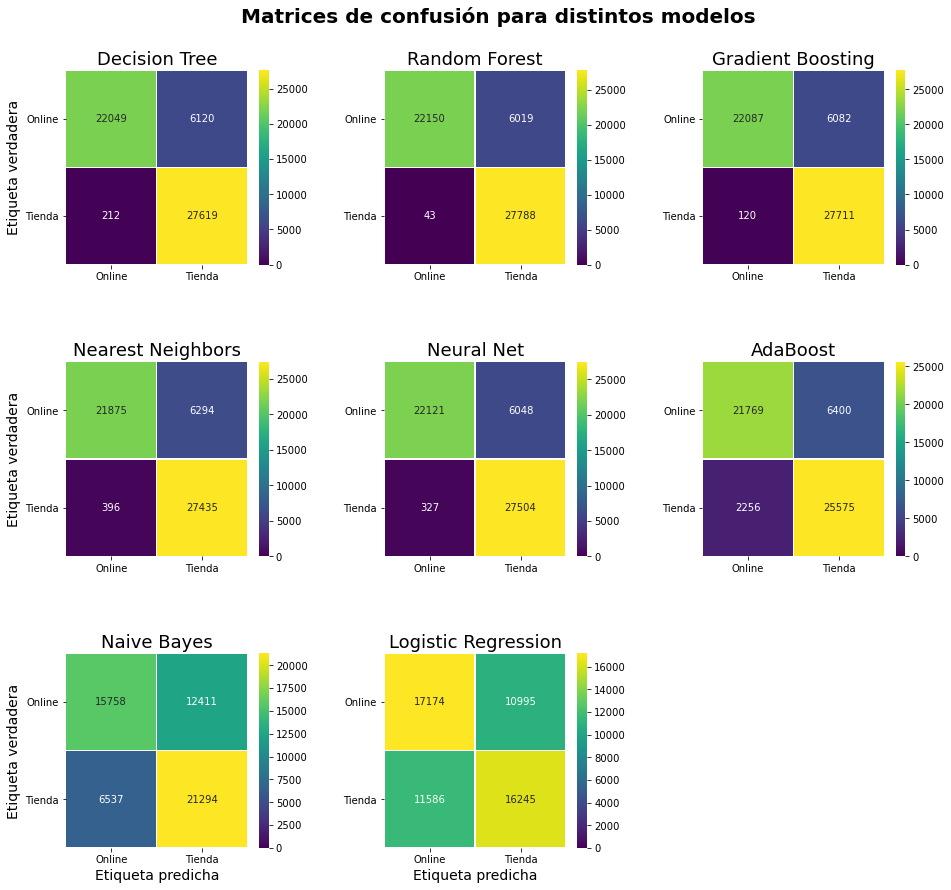

In [84]:
fig, axs = plt.subplots(3,3)
j=-1
for name in mod_entrenados.keys():
    j=j+1
    sns.heatmap(mod_entrenados[name]['Conf_mat'], vmin=0,annot=True,cmap='viridis', fmt='1.0f',linewidths=.2, ax=axs[j//3,j%3])
    axs[j//3,j%3].set_title(name, fontsize=18)
    if j//3==2 : axs[j//3,j%3].set_xlabel('Etiqueta predicha',size=14)
    if j%3 ==0: axs[j//3,j%3].set_ylabel('Etiqueta verdadera',size=14)
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2, 
                    top=2.7, 
                    wspace=0.4, 
                    hspace=0.5)
 
axs[-1, -1].axis('off')
fig.suptitle('Matrices de confusión para distintos modelos', size=20, x=1, y=2.92, fontweight ="bold")
plt.show()

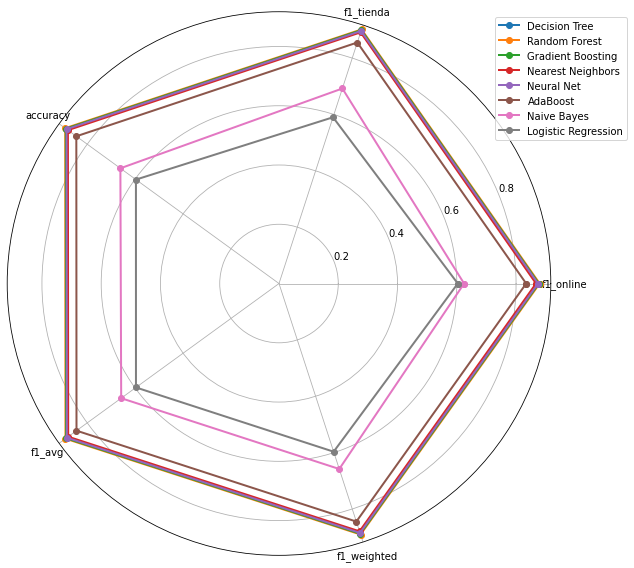

In [85]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
#ax.set_rlim([0.55,0.65])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for name in mod_entrenados.keys():
    stats= mod_entrenados[name]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=name)
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

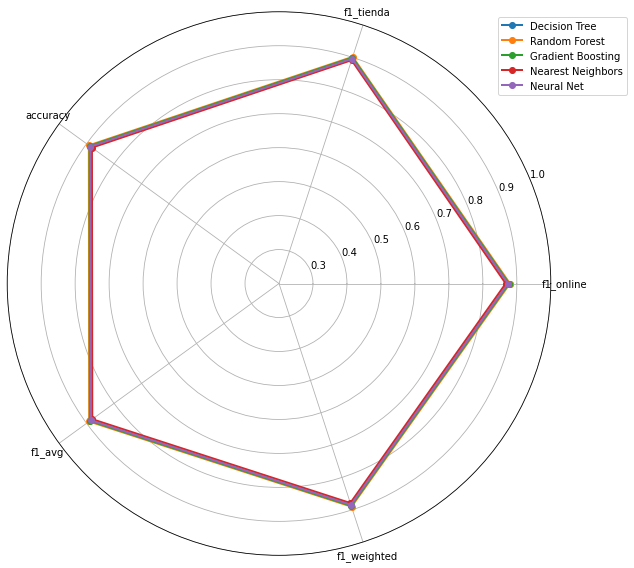

In [86]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
ax.set_rlim([0.2,1])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for i in range(5):
    stats= mod_entrenados[list(mod_entrenados.keys())[i]]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=list(mod_entrenados.keys())[i])
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

# Sin bins y sin items

## Carga y división de datos

In [18]:
#features
X_si = data.iloc[:,[0,1,3]]
y_si = data.iloc[:,4]

In [19]:
#Train/Test Split (que conste que esta división no separa a partes iguales los datos de cada region, y esto puede ser un fallo)
X_si_train, X_si_test, y_si_train, y_si_test = train_test_split(X_si, y_si, test_size = .30, random_state = 123)

In [20]:
scaler_si = preprocessing.StandardScaler().fit(X_si_train.iloc[:,0:3])
X_si_tr_scaled = scaler_si.transform(X_si_train.iloc[:,0:3])
X_si_tr_scaled=pd.DataFrame(X_si_tr_scaled, columns=X_si_train.columns[0:3], index=X_si_train.index)

## Uso GridSearchCV

In [21]:
scorr = {'Accuracy': 'accuracy', 'F1_avg': 'f1_weighted'}
cosas=[scorr.keys(),['mean_test_','rank_test_']]
cosas0=[]
for element in itertools.product(*cosas):
        cosas0.append(element[1]+element[0])

In [22]:
#Por defecto toma cv=5

mod_entrenados_si={}

for name in dict_modelos.keys():
    names_col_imp=[]
    cosas1=['param_'+v for v in dict_modelos[name]['Params'].keys()]
    names_col_imp=['params']+cosas1+cosas0
    
    gs = GridSearchCV(dict_modelos[name]['Modelo'],
                      param_grid=dict_modelos[name]['Params'],
                      scoring=scorr, refit='F1_avg', cv=5)
    gs.fit(X_si_tr_scaled, y_si_train)
    mod_entrenados_si[name]={'Mod_ent': gs, 'Tabla': pd.DataFrame(gs.cv_results_)[names_col_imp], 'Best': gs.best_estimator_}
    print(f'Para el modelo {name}, el mejor estimador es {gs.best_estimator_}.')
    print()
mod_entrenados_si['Neural Net']['Tabla']['param_hidden_layer_sizes']=list(range(20,101,10))

Para el modelo Decision Tree, el mejor estimador es DecisionTreeClassifier(max_depth=9).

Para el modelo Random Forest, el mejor estimador es RandomForestClassifier(max_depth=12).

Para el modelo Gradient Boosting, el mejor estimador es GradientBoostingClassifier(max_depth=4).

Para el modelo Nearest Neighbors, el mejor estimador es KNeighborsClassifier(n_neighbors=55).

Para el modelo Neural Net, el mejor estimador es MLPClassifier(max_iter=1000).



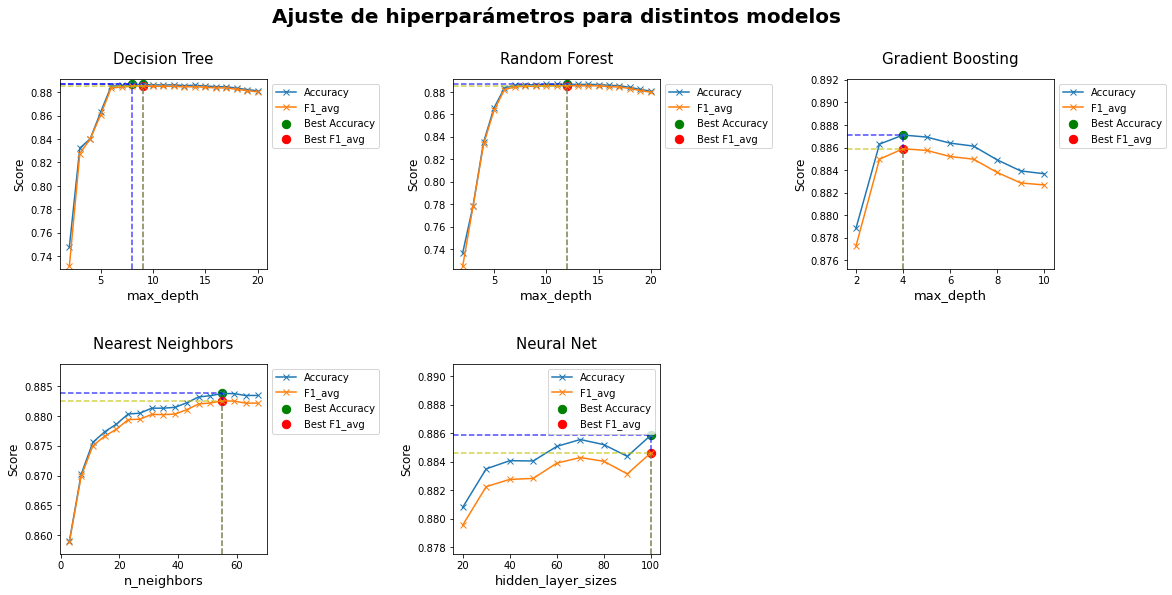

In [23]:
color = ['b', 'y']
color2 = ['g', 'r']
fig, axes_gs = plt.subplots(2,3)

j = -1
for n in mod_entrenados_si.keys():
    j = j+1
    colu = 'param_'+list(parametros[j])[0]
    if j==0:
        resultados = mod_entrenados_si[n]['Tabla'][mod_entrenados_si[n]['Tabla']['param_min_samples_split']==2]
    else :
        resultados = mod_entrenados_si[n]['Tabla']
    axes_gs[j//3,j%3].set_ylim(min(resultados.iloc[:,-4].min(), resultados.iloc[:,-2].min())-0.002, max(resultados.iloc[:,-4].max(),resultados.iloc[:,-2].max())+0.005)
    for i in range(len(scorr)):   
        axes_gs[j//3,j%3].plot(resultados[colu], resultados.iloc[:,2*i-4], 'x-', label=list(scorr.keys())[i])
        fff=resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()]
        axes_gs[j//3,j%3].scatter(fff,np.full((1,len(fff)),resultados.iloc[:,2*i-4].max()), s=70, color = color2[i], label='Best '+list(scorr.keys())[i])
        limite_y=(resultados.iloc[:,2*i-4].max()-axes_gs[j//3,j%3].set_ylim()[0])/(axes_gs[j//3,j%3].set_ylim()[1]-axes_gs[j//3,j%3].set_ylim()[0])
        for k in range(len(fff)):
            limite_x=(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k]-axes_gs[j//3,j%3].set_xlim()[0])/(axes_gs[j//3,j%3].set_xlim()[1]-axes_gs[j//3,j%3].set_xlim()[0])
            axes_gs[j//3,j%3].axhline(resultados.iloc[:,2*i-4].max(), xmax=limite_x, ls='--', color=color[i], alpha=0.7)
            axes_gs[j//3,j%3].axvline(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k], ymax=limite_y, ls='--', color=color[i], alpha=0.7)
    axes_gs[j//3,j%3].legend(bbox_to_anchor=(1, 1))
    axes_gs[j//3,j%3].set_xlabel(list(parametros[j])[0], size=13)
    axes_gs[j//3,j%3].set_ylabel('Score', size=12)
    axes_gs[j//3,j%3].set_title(n, size=15, y =1.05)

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2.3, 
                    top=1.65, 
                    wspace=0.9, 
                    hspace=0.5)
axes_gs[-1, -1].axis('off')
fig.suptitle('Ajuste de hiperparámetros para distintos modelos', size=20, x=1.15, y=1.9, fontweight ="bold")
plt.show()
#plt.xticks(list(range(0,29)), resultados.param_max_depth);

In [26]:
mod_entrenados_si.update(dict_otros_modelos)

## Entreno los best estimator y comparo

Primero modificamos los datos X_test para adecuarlos a la escala:

In [27]:
X_si_test_scaled = scaler_si.transform(X_si_test.iloc[:,0:3])
X_si_test_scaled=pd.DataFrame(X_si_test_scaled, columns=X_si_test.columns[0:3], index=X_si_test.index)

In [87]:
regiones=['Online','Tienda','Accuracy','Macro_avg','Weighted_avg']
for name in mod_entrenados_si.keys():
    model = mod_entrenados_si[name]['Best'].fit(X_si_tr_scaled, y_si_train)
    preds = model.predict(X_si_tr_scaled)
    mod_entrenados_si[name]['Preds_for_best'] = preds
    mod_entrenados_si[name]['Class_report'] = pd.DataFrame(classification_report(y_si_train, preds, output_dict=True)).transpose()
    mod_entrenados_si[name]['Class_report'].index=regiones
    try :
        mod_entrenados_si[name]['Imp_features'] = pd.DataFrame(model.feature_importances_, index=X_si_tr_scaled.columns, columns=['Importance']).transpose()
    except:
        pass
    confmatriz=pd.DataFrame([confusion_matrix(y_si_train, preds)[i,:] for i in range(2)],
                        index=['Online','Tienda'],
                        columns=['Online','Tienda'])
    mod_entrenados_si[name]['Conf_mat']=confmatriz   
    print(name)

Decision Tree
Random Forest
Gradient Boosting
Nearest Neighbors
Neural Net
AdaBoost
Naive Bayes
Logistic Regression


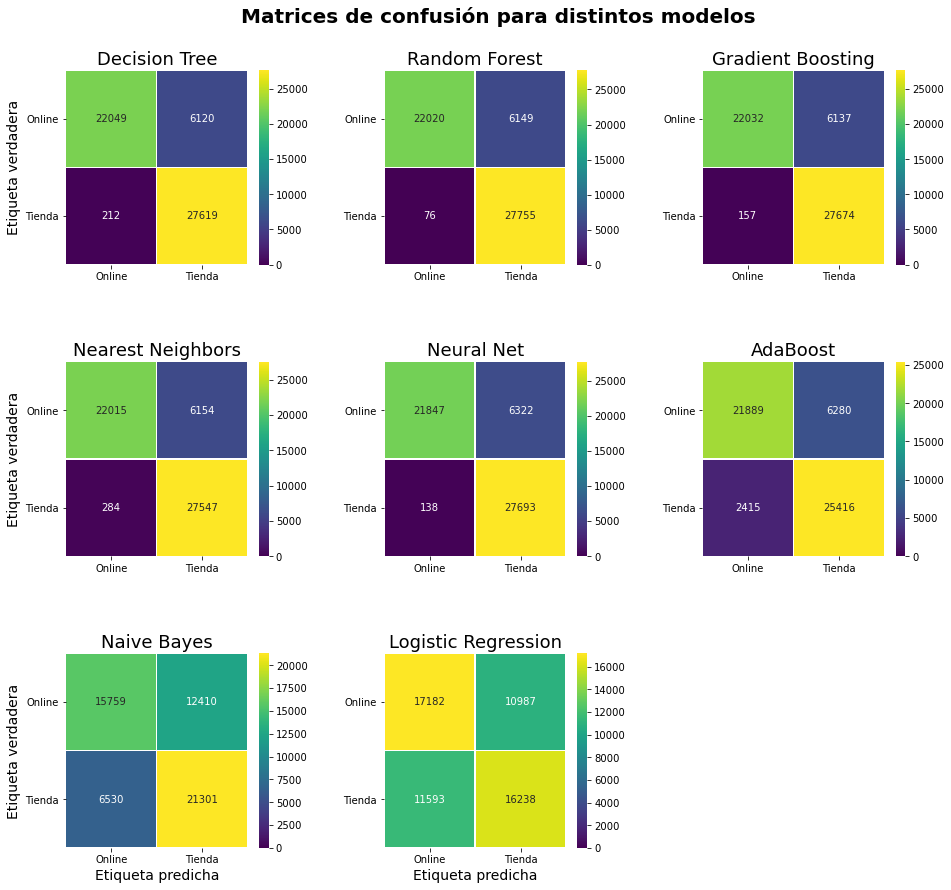

In [88]:
fig, axs = plt.subplots(3,3)
j=-1
for name in mod_entrenados_si.keys():
    j=j+1
    sns.heatmap(mod_entrenados_si[name]['Conf_mat'], vmin=0,annot=True,cmap='viridis', fmt='1.0f',linewidths=.2, ax=axs[j//3,j%3])
    axs[j//3,j%3].set_title(name, fontsize=18)
    if j//3==2 : axs[j//3,j%3].set_xlabel('Etiqueta predicha',size=14)
    if j%3 ==0: axs[j//3,j%3].set_ylabel('Etiqueta verdadera',size=14)
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2, 
                    top=2.7, 
                    wspace=0.4, 
                    hspace=0.5)
 
axs[-1, -1].axis('off')
fig.suptitle('Matrices de confusión para distintos modelos', size=20, x=1, y=2.92, fontweight ="bold")
plt.show()

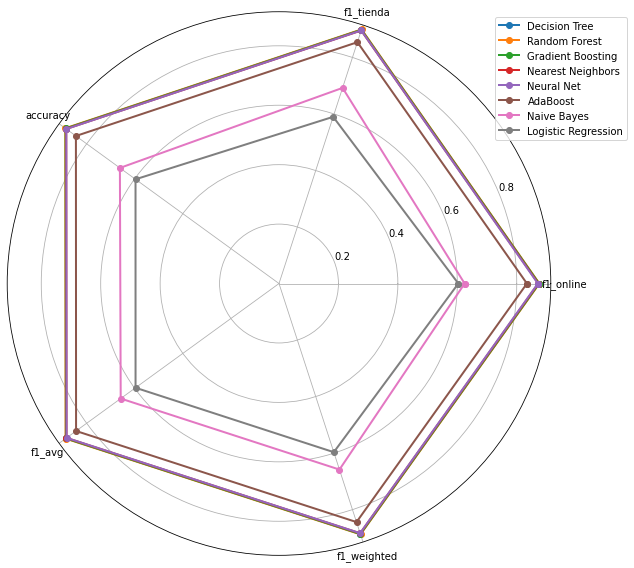

In [89]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
#ax.set_rlim([0.55,0.65])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for name in mod_entrenados_si.keys():
    stats= mod_entrenados_si[name]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=name)
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

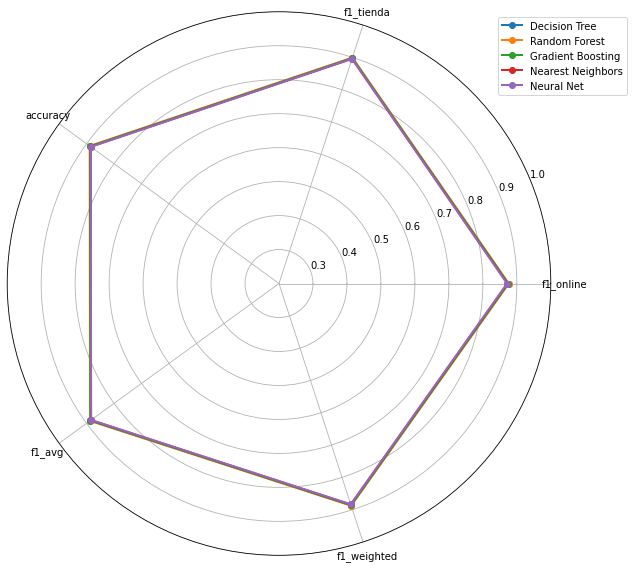

In [90]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
ax.set_rlim([0.2,1])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for i in range(5):
    stats= mod_entrenados_si[list(mod_entrenados_si.keys())[i]]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=list(mod_entrenados_si.keys())[i])
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

# Con bins míos y con items

## Carga y división de datos

In [32]:
bins=np.array([17.999,25.001,35.001,45.001,55.001,65.001,75.001,85.001,0,500.0001,1000.0001,1500.0001,2000.0001,2500.0001,3000.1])
true_bins=np.array([18,25,35,45,55,65,75,85,0,500,1000,1500,2000,2500,3000])
names_amount=['[0-500]','(500-1000]','(1000-1500]','(1500-2000]','(2000-2500]','(2500-3000]']
names_ages=['18-25','26-35','36-45','46-55','56-65','66-75','76-85']

In [33]:
agrupa_ages = np.digitize(data.Age, bins[0:8])
agrupa_amount = np.digitize(data.Amount, bins[8:])
amount_df=pd.DataFrame({'Amount in bins': agrupa_amount},index=range(len(data)))
ages_df=pd.DataFrame({'Age in bins': agrupa_ages},index=range(len(data)))

In [34]:
data_todo=pd.concat([data,ages_df],axis=1)
data_todo=pd.concat([data_todo,amount_df],axis=1)
data_bins=data_todo.drop(columns=['Age','Amount'])
data_bins=data_bins[['Region','Age in bins','Items','Amount in bins','In-store']]

In [35]:
#features
Xb = data_bins.iloc[:,0:4]
yb = data_bins.iloc[:,4]

In [36]:
#Train/Test Split (que conste que esta división no separa a partes iguales los datos de cada region, y esto puede ser un fallo)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size = .30, random_state = 123)

In [37]:
scalerb = preprocessing.StandardScaler().fit(Xb_train.iloc[:,0:4])
Xb_tr_scaled = scalerb.transform(Xb_train.iloc[:,0:4])
Xb_tr_scaled=pd.DataFrame(Xb_tr_scaled, columns=Xb_train.columns[0:4], index=Xb_train.index)

## Uso GridSearchCV

In [38]:
scorr = {'Accuracy': 'accuracy', 'F1_avg': 'f1_weighted'}
cosas=[scorr.keys(),['mean_test_','rank_test_']]
cosas0=[]
for element in itertools.product(*cosas):
        cosas0.append(element[1]+element[0])

In [39]:
#Por defecto toma cv=5

mod_entrenados_b={}

for name in dict_modelos.keys():
    names_col_imp=[]
    cosas1=['param_'+v for v in dict_modelos[name]['Params'].keys()]
    names_col_imp=['params']+cosas1+cosas0
    
    gs = GridSearchCV(dict_modelos[name]['Modelo'],
                      param_grid=dict_modelos[name]['Params'],
                      scoring=scorr, refit='F1_avg', cv=5)
    gs.fit(Xb_tr_scaled, yb_train)
    mod_entrenados_b[name]={'Mod_ent': gs, 'Tabla': pd.DataFrame(gs.cv_results_)[names_col_imp], 'Best': gs.best_estimator_}
    print(f'Para el modelo {name}, el mejor estimador es {gs.best_estimator_}.')
    print()
mod_entrenados_b['Neural Net']['Tabla']['param_hidden_layer_sizes']=list(range(20,101,10))

Para el modelo Decision Tree, el mejor estimador es DecisionTreeClassifier(max_depth=6).

Para el modelo Random Forest, el mejor estimador es RandomForestClassifier(max_depth=10).

Para el modelo Gradient Boosting, el mejor estimador es GradientBoostingClassifier(max_depth=6).

Para el modelo Nearest Neighbors, el mejor estimador es KNeighborsClassifier(n_neighbors=67).

Para el modelo Neural Net, el mejor estimador es MLPClassifier(hidden_layer_sizes=(90,), max_iter=1000).



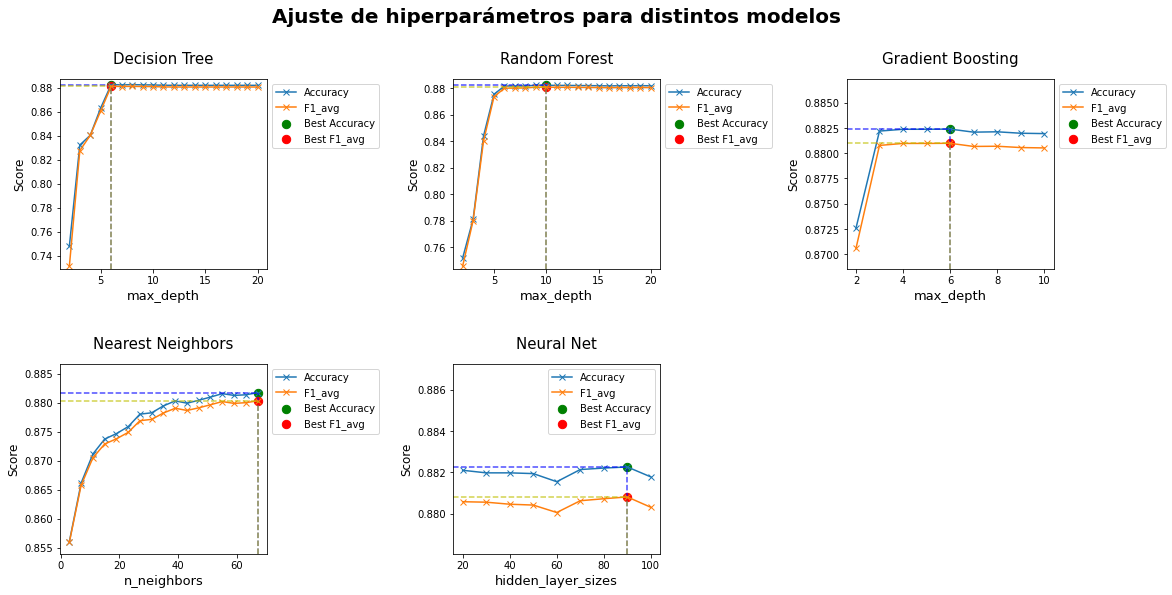

In [40]:
color = ['b', 'y']
color2 = ['g', 'r']
fig, axes_gs = plt.subplots(2,3)

j = -1
for n in mod_entrenados_b.keys():
    j = j+1
    colu = 'param_'+list(parametros[j])[0]
    if j==0:
        resultados = mod_entrenados_b[n]['Tabla'][mod_entrenados_b[n]['Tabla']['param_min_samples_split']==2]
    else :
        resultados = mod_entrenados_b[n]['Tabla']
    axes_gs[j//3,j%3].set_ylim(min(resultados.iloc[:,-4].min(), resultados.iloc[:,-2].min())-0.002, max(resultados.iloc[:,-4].max(),resultados.iloc[:,-2].max())+0.005)
    for i in range(len(scorr)):   
        axes_gs[j//3,j%3].plot(resultados[colu], resultados.iloc[:,2*i-4], 'x-', label=list(scorr.keys())[i])
        fff=resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()]
        axes_gs[j//3,j%3].scatter(fff,np.full((1,len(fff)),resultados.iloc[:,2*i-4].max()), s=70, color = color2[i], label='Best '+list(scorr.keys())[i])
        limite_y=(resultados.iloc[:,2*i-4].max()-axes_gs[j//3,j%3].set_ylim()[0])/(axes_gs[j//3,j%3].set_ylim()[1]-axes_gs[j//3,j%3].set_ylim()[0])
        for k in range(len(fff)):
            limite_x=(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k]-axes_gs[j//3,j%3].set_xlim()[0])/(axes_gs[j//3,j%3].set_xlim()[1]-axes_gs[j//3,j%3].set_xlim()[0])
            axes_gs[j//3,j%3].axhline(resultados.iloc[:,2*i-4].max(), xmax=limite_x, ls='--', color=color[i], alpha=0.7)
            axes_gs[j//3,j%3].axvline(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k], ymax=limite_y, ls='--', color=color[i], alpha=0.7)
    axes_gs[j//3,j%3].legend(bbox_to_anchor=(1, 1))
    axes_gs[j//3,j%3].set_xlabel(list(parametros[j])[0], size=13)
    axes_gs[j//3,j%3].set_ylabel('Score', size=12)
    axes_gs[j//3,j%3].set_title(n, size=15, y =1.05)

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2.3, 
                    top=1.65, 
                    wspace=0.9, 
                    hspace=0.5)
axes_gs[-1, -1].axis('off')
fig.suptitle('Ajuste de hiperparámetros para distintos modelos', size=20, x=1.15, y=1.9, fontweight ="bold")
plt.show()
#plt.xticks(list(range(0,29)), resultados.param_max_depth);

In [41]:
mod_entrenados_b.update(dict_otros_modelos)

## Entreno los best estimator y comparo

In [42]:
Xb_test_scaled = scalerb.transform(Xb_test.iloc[:,0:4])
Xb_test_scaled=pd.DataFrame(Xb_test_scaled, columns=Xb_test.columns[0:4], index=Xb_test.index)

In [91]:
regiones=['Online','Tienda','Accuracy','Macro_avg','Weighted_avg']
for name in mod_entrenados_b.keys():
    model = mod_entrenados_b[name]['Best'].fit(Xb_tr_scaled, yb_train)
    preds = model.predict(Xb_tr_scaled)
    mod_entrenados_b[name]['Preds_for_best'] = preds
    mod_entrenados_b[name]['Class_report'] = pd.DataFrame(classification_report(yb_train, preds, output_dict=True)).transpose()
    mod_entrenados_b[name]['Class_report'].index=regiones
    try :
        mod_entrenados_b[name]['Imp_features'] = pd.DataFrame(model.feature_importances_, index=Xb_tr_scaled.columns, columns=['Importance']).transpose()
    except:
        pass
    confmatriz=pd.DataFrame([confusion_matrix(yb_train, preds)[i,:] for i in range(2)],
                        index=['Online','Tienda'],
                        columns=['Online','Tienda'])
    mod_entrenados_b[name]['Conf_mat']=confmatriz   
    print(name)

Decision Tree
Random Forest
Gradient Boosting
Nearest Neighbors
Neural Net
AdaBoost
Naive Bayes
Logistic Regression


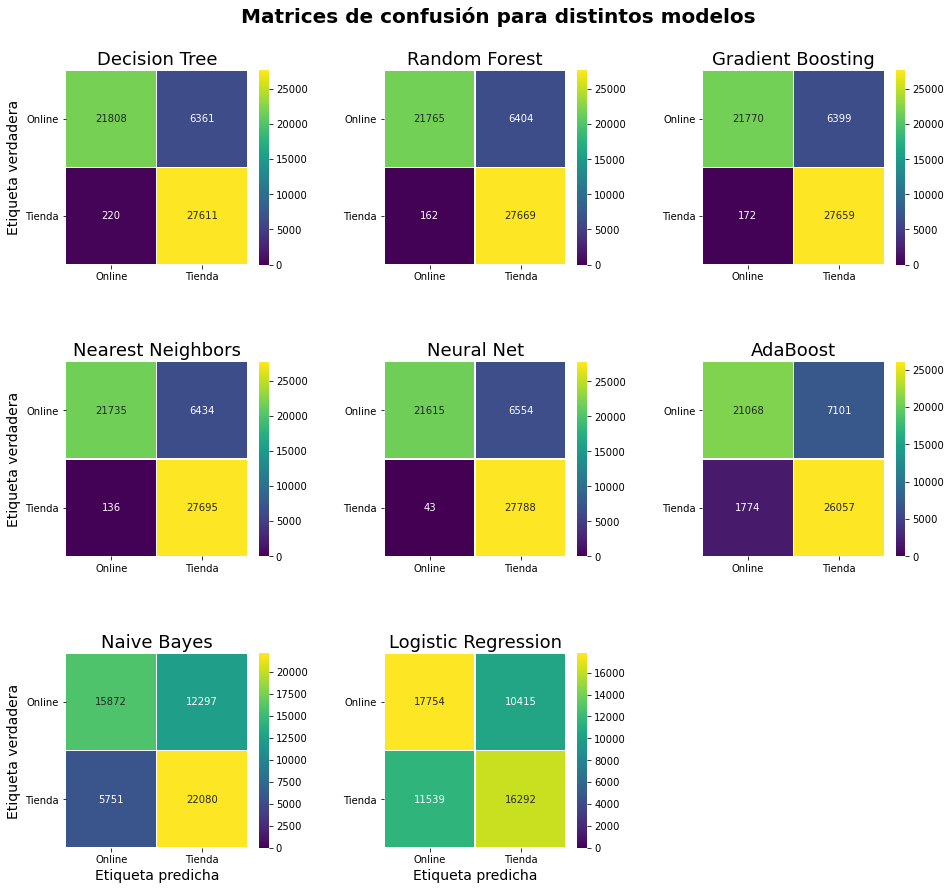

In [92]:
fig, axs = plt.subplots(3,3)
j=-1
for name in mod_entrenados_b.keys():
    j=j+1
    sns.heatmap(mod_entrenados_b[name]['Conf_mat'], vmin=0,annot=True,cmap='viridis', fmt='1.0f',linewidths=.2, ax=axs[j//3,j%3])
    axs[j//3,j%3].set_title(name, fontsize=18)
    if j//3==2 : axs[j//3,j%3].set_xlabel('Etiqueta predicha',size=14)
    if j%3 ==0: axs[j//3,j%3].set_ylabel('Etiqueta verdadera',size=14)
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2, 
                    top=2.7, 
                    wspace=0.4, 
                    hspace=0.5)
 
axs[-1, -1].axis('off')
fig.suptitle('Matrices de confusión para distintos modelos', size=20, x=1, y=2.92, fontweight ="bold")
plt.show()

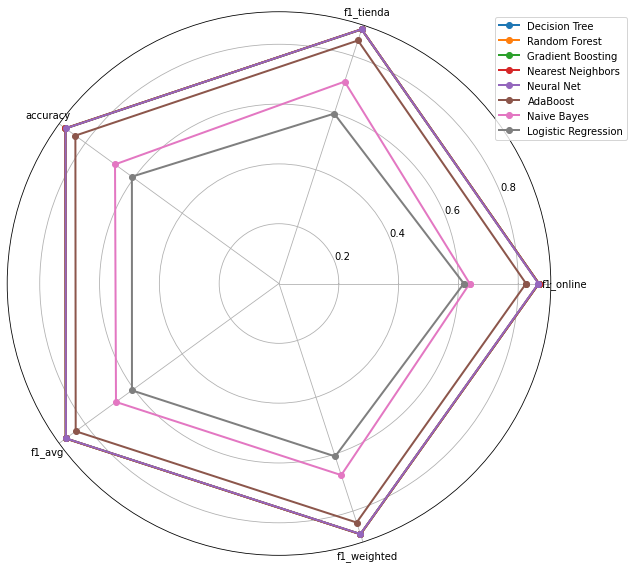

In [93]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
#ax.set_rlim([0.55,0.65])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for name in mod_entrenados_b.keys():
    stats= mod_entrenados_b[name]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=name)
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

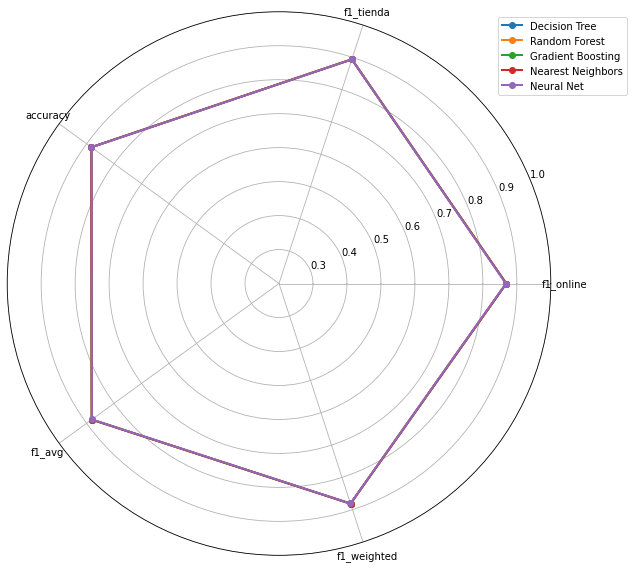

In [95]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
ax.set_rlim([0.2,1])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for i in range(5):
    stats= mod_entrenados_b[list(mod_entrenados_b.keys())[i]]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=list(mod_entrenados_b.keys())[i])
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

# Con bins míos y sin items

## Carga y división de datos

In [60]:
Xb_si = data_bins.iloc[:,[0,1,3]]
yb_si = data_bins.iloc[:,4]

In [61]:
#Train/Test Split (que conste que esta división no separa a partes iguales los datos de cada region, y esto puede ser un fallo)
Xb_si_train, Xb_si_test, yb_si_train, yb_si_test = train_test_split(Xb_si, yb_si, test_size = .30, random_state = 123)

In [62]:
scalerb_si = preprocessing.StandardScaler().fit(Xb_si_train.iloc[:,0:3])
Xb_si_tr_scaled = scalerb_si.transform(Xb_si_train.iloc[:,0:3])
Xb_si_tr_scaled=pd.DataFrame(Xb_si_tr_scaled, columns=Xb_si_train.columns[0:3], index=Xb_si_train.index)

## Uso GridSearchCV

In [63]:
scorr = {'Accuracy': 'accuracy', 'F1_avg': 'f1_weighted'}
cosas=[scorr.keys(),['mean_test_','rank_test_']]
cosas0=[]
for element in itertools.product(*cosas):
        cosas0.append(element[1]+element[0])

In [64]:
#Por defecto toma cv=5

mod_entrenados_b_si={}

for name in dict_modelos.keys():
    names_col_imp=[]
    cosas1=['param_'+v for v in dict_modelos[name]['Params'].keys()]
    names_col_imp=['params']+cosas1+cosas0
    
    gs = GridSearchCV(dict_modelos[name]['Modelo'],
                      param_grid=dict_modelos[name]['Params'],
                      scoring=scorr, refit='F1_avg', cv=5)
    gs.fit(Xb_si_tr_scaled, yb_si_train)
    mod_entrenados_b_si[name]={'Mod_ent': gs, 'Tabla': pd.DataFrame(gs.cv_results_)[names_col_imp], 'Best': gs.best_estimator_}
    print(f'Para el modelo {name}, el mejor estimador es {gs.best_estimator_}.')
    print()
mod_entrenados_b_si['Neural Net']['Tabla']['param_hidden_layer_sizes']=list(range(20,101,10))

Para el modelo Decision Tree, el mejor estimador es DecisionTreeClassifier(max_depth=6).

Para el modelo Random Forest, el mejor estimador es RandomForestClassifier(max_depth=17).

Para el modelo Gradient Boosting, el mejor estimador es GradientBoostingClassifier(max_depth=4).

Para el modelo Nearest Neighbors, el mejor estimador es KNeighborsClassifier(n_neighbors=67).

Para el modelo Neural Net, el mejor estimador es MLPClassifier(hidden_layer_sizes=(80,), max_iter=1000).



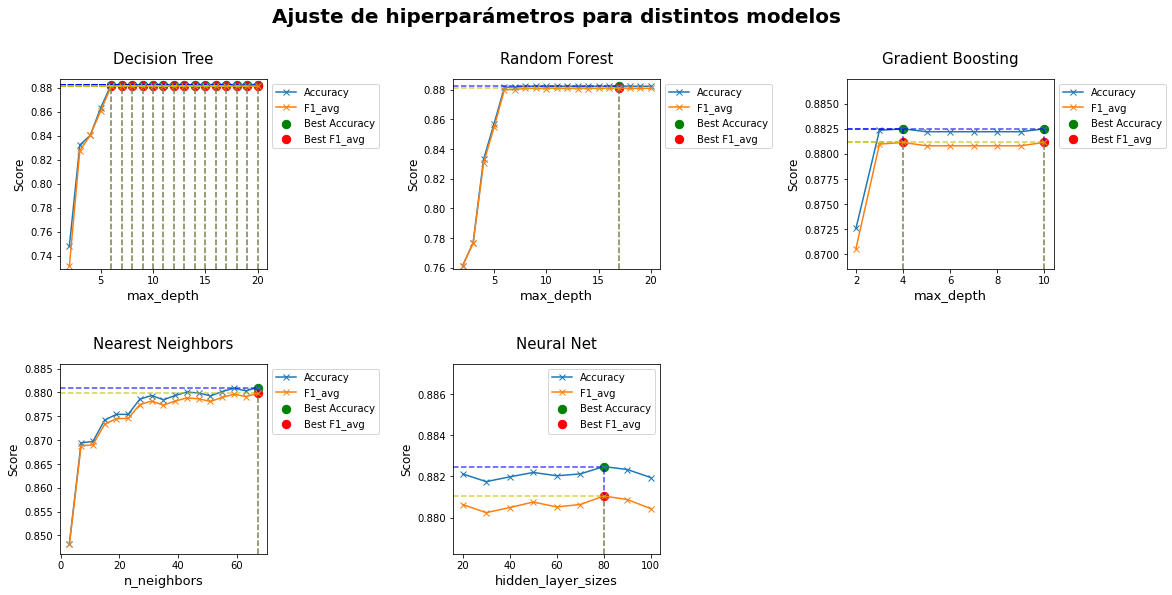

In [65]:
color = ['b', 'y']
color2 = ['g', 'r']
fig, axes_gs = plt.subplots(2,3)

j = -1
for n in mod_entrenados_b_si.keys():
    j = j+1
    colu = 'param_'+list(parametros[j])[0]
    if j==0:
        resultados = mod_entrenados_b_si[n]['Tabla'][mod_entrenados_b_si[n]['Tabla']['param_min_samples_split']==2]
    else :
        resultados = mod_entrenados_b_si[n]['Tabla']
    axes_gs[j//3,j%3].set_ylim(min(resultados.iloc[:,-4].min(), resultados.iloc[:,-2].min())-0.002, max(resultados.iloc[:,-4].max(),resultados.iloc[:,-2].max())+0.005)
    for i in range(len(scorr)):   
        axes_gs[j//3,j%3].plot(resultados[colu], resultados.iloc[:,2*i-4], 'x-', label=list(scorr.keys())[i])
        fff=resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()]
        axes_gs[j//3,j%3].scatter(fff,np.full((1,len(fff)),resultados.iloc[:,2*i-4].max()), s=70, color = color2[i], label='Best '+list(scorr.keys())[i])
        limite_y=(resultados.iloc[:,2*i-4].max()-axes_gs[j//3,j%3].set_ylim()[0])/(axes_gs[j//3,j%3].set_ylim()[1]-axes_gs[j//3,j%3].set_ylim()[0])
        for k in range(len(fff)):
            limite_x=(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k]-axes_gs[j//3,j%3].set_xlim()[0])/(axes_gs[j//3,j%3].set_xlim()[1]-axes_gs[j//3,j%3].set_xlim()[0])
            axes_gs[j//3,j%3].axhline(resultados.iloc[:,2*i-4].max(), xmax=limite_x, ls='--', color=color[i], alpha=0.7)
            axes_gs[j//3,j%3].axvline(resultados[colu][resultados.iloc[:,2*i-3]==resultados.iloc[:,2*i-3].min()].unique()[k], ymax=limite_y, ls='--', color=color[i], alpha=0.7)
    axes_gs[j//3,j%3].legend(bbox_to_anchor=(1, 1))
    axes_gs[j//3,j%3].set_xlabel(list(parametros[j])[0], size=13)
    axes_gs[j//3,j%3].set_ylabel('Score', size=12)
    axes_gs[j//3,j%3].set_title(n, size=15, y =1.05)

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2.3, 
                    top=1.65, 
                    wspace=0.9, 
                    hspace=0.5)
axes_gs[-1, -1].axis('off')
fig.suptitle('Ajuste de hiperparámetros para distintos modelos', size=20, x=1.15, y=1.9, fontweight ="bold")
plt.show()
#plt.xticks(list(range(0,29)), resultados.param_max_depth);

In [66]:
mod_entrenados_b_si.update(dict_otros_modelos)

## Entreno los best estimator y comparo

In [67]:
Xb_si_test_scaled = scalerb_si.transform(Xb_si_test.iloc[:,0:3])
Xb_si_test_scaled=pd.DataFrame(Xb_si_test_scaled, columns=Xb_si_test.columns[0:3], index=Xb_si_test.index)

In [96]:
regiones=['Online','Tienda','Accuracy','Macro_avg','Weighted_avg']
for name in mod_entrenados_b_si.keys():
    model = mod_entrenados_b_si[name]['Best'].fit(Xb_si_tr_scaled, yb_si_train)
    preds = model.predict(Xb_si_tr_scaled)
    mod_entrenados_b_si[name]['Preds_for_best'] = preds
    mod_entrenados_b_si[name]['Class_report'] = pd.DataFrame(classification_report(yb_si_train, preds, output_dict=True)).transpose()
    mod_entrenados_b_si[name]['Class_report'].index=regiones
    try :
        mod_entrenados_b_si[name]['Imp_features'] = pd.DataFrame(model.feature_importances_, index=Xb_si_tr_scaled.columns, columns=['Importance']).transpose()
    except:
        pass
    confmatriz=pd.DataFrame([confusion_matrix(yb_si_train, preds)[i,:] for i in range(2)],
                        index=['Online','Tienda'],
                        columns=['Online','Tienda'])
    mod_entrenados_b_si[name]['Conf_mat']=confmatriz   
    print(name)

Decision Tree
Random Forest
Gradient Boosting
Nearest Neighbors
Neural Net
AdaBoost
Naive Bayes
Logistic Regression


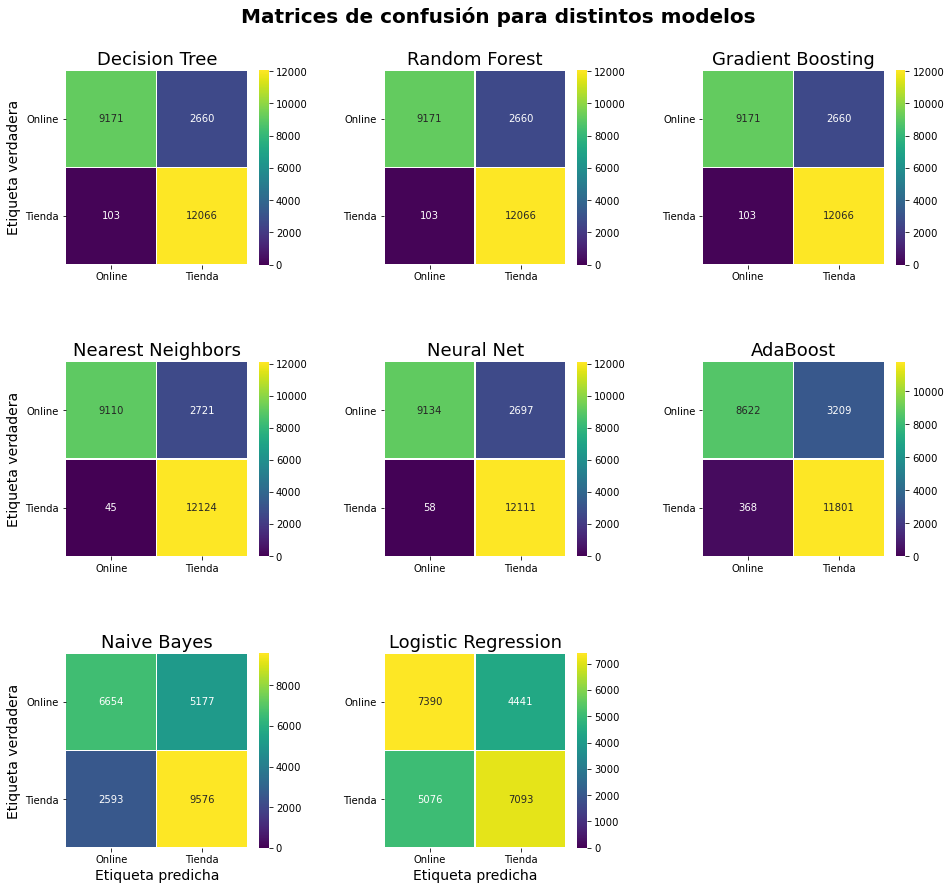

In [69]:
fig, axs = plt.subplots(3,3)
j=-1
for name in mod_entrenados_b_si.keys():
    j=j+1
    sns.heatmap(mod_entrenados_b_si[name]['Conf_mat'], vmin=0,annot=True,cmap='viridis', fmt='1.0f',linewidths=.2, ax=axs[j//3,j%3])
    axs[j//3,j%3].set_title(name, fontsize=18)
    if j//3==2 : axs[j//3,j%3].set_xlabel('Etiqueta predicha',size=14)
    if j%3 ==0: axs[j//3,j%3].set_ylabel('Etiqueta verdadera',size=14)
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2, 
                    top=2.7, 
                    wspace=0.4, 
                    hspace=0.5)
 
axs[-1, -1].axis('off')
fig.suptitle('Matrices de confusión para distintos modelos', size=20, x=1, y=2.92, fontweight ="bold")
plt.show()

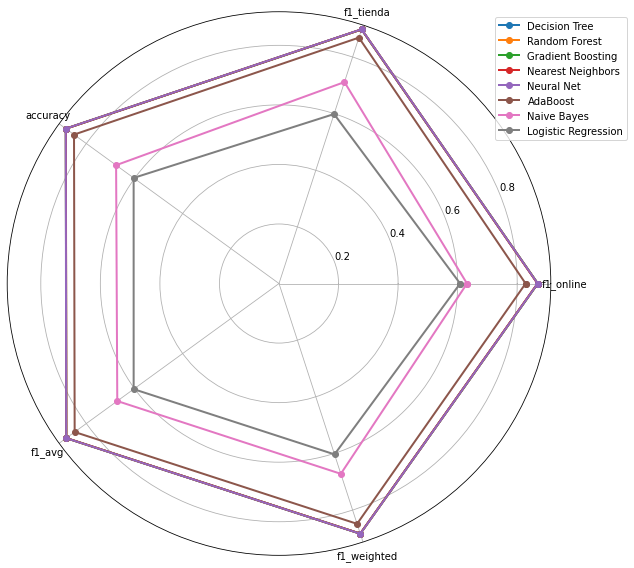

In [70]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
#ax.set_rlim([0.55,0.65])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for name in mod_entrenados_b_si.keys():
    stats= mod_entrenados_b_si[name]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=name)
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

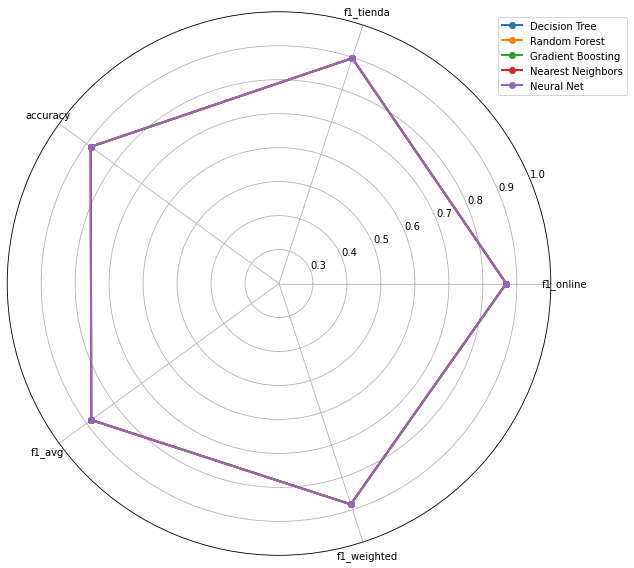

In [71]:
labels=['f1_online', 'f1_tienda', 'accuracy','f1_avg', 'f1_weighted']
color=['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey']
# Preparación de datos de dibujo, ángulo, valor de estado
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
# Usa Matplotlib para dibujar diagramas de araña
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, polar=True)
ax.set_thetagrids(angles[0:5] * 180/np.pi, labels)
ax.set_rlim([0.2,1])
#ax.set_rticks([0.58,0.62])

#for i in range(2):
for i in range(5):
    stats= mod_entrenados_b_si[list(mod_entrenados_b_si.keys())[i]]['Class_report']['f1-score']
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2, label=list(mod_entrenados_b_si.keys())[i])
#    ax.fill(angles, stats, alpha=0.25)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

# Eligiendo el mejor modelo

In [77]:
lista_modelos=[mod_entrenados,mod_entrenados_si,mod_entrenados_b,mod_entrenados_b_si]
li_mod=['mod_entrenados ','mod_entrenados_si ','mod_entrenados_b ','mod_entrenados_b_si ']

In [79]:
todos_modelos_acc={}
todos_modelos_f1={}
todos_modelos_mean={}
for i in range(len(lista_modelos)):
    for name2 in lista_modelos[i]:
        todos_modelos_acc[li_mod[i]+name2] = lista_modelos[i][name2]['Class_report']['f1-score'][-3]
        todos_modelos_f1[li_mod[i]+name2] = lista_modelos[i][name2]['Class_report']['f1-score'][-1] 
        todos_modelos_mean[li_mod[i]+name2] = (todos_modelos_acc[li_mod[i]+name2]+todos_modelos_f1[li_mod[i]+name2])/2

In [80]:
def maxdict(di):
    f=0
    ff=''
    for n, m in di.items():
        if m>f: 
            f=m
            ff=n
    return ff

In [81]:
mas_acc=maxdict(todos_modelos_acc)
mas_f1=maxdict(todos_modelos_f1)
mas_mean=maxdict(todos_modelos_mean)
print(f'El modelo con mayor accuracy es {mas_acc}: {todos_modelos_acc[mas_acc]}')
print(f'El modelo con mayor f1-score es {mas_f1}: {todos_modelos_f1[mas_f1]}')
print(f'El modelo con mayor score medio es {mas_mean}: {todos_modelos_mean[mas_mean]}')

El modelo con mayor accuracy es mod_entrenados_si Random Forest: 0.889875
El modelo con mayor f1-score es mod_entrenados_si Random Forest: 0.8884345289221389
El modelo con mayor score medio es mod_entrenados_si Random Forest: 0.8891547644610694


In [82]:
mod_entrenados_si['Random Forest']['Best']

RandomForestClassifier(max_depth=12)

In [ ]:
mejor_model = mod_entrenados_b['Naive Bayes']['Best'].fit(Xb_tr_scaled, yb_train)
preds = mejor_model.predict(Xb_test_scaled)
class_rep_mejor_model= pd.DataFrame(classification_report(yb_test, preds, output_dict=True)).transpose()
class_rep_mejor_model.index=regiones
class_rep_mejor_model